# Support Vector Machines

In [2]:
# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import basic tools
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

## Linear SVM Classification

- SVM对数据比较敏感，所以在进行训练之前必须进行Scale

- 同时必须对训练数据转换为中心对称（减去平均值），StandardScaler已经自动完成了这步操作

- C值越大，边界越苛刻

In [2]:
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris['data'][:, (2, 3)] # petal length, petal width
y = (iris['target'] == 2).astype(np.float64) # Iris-Virginica

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss='hinge')),
])
svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [3]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

### 注意：

- 相比于LinearSVC(...)，使用SVC(kernel="linear", C=1)，可以获得更好地效果，但训练时间比较长

- 处理大数据集时，如果空间不够可使用SGD模型

- 如果feature个数大于训练集个数，可设置dual=True, 其他情况设置为False

## Nonelinear SVM Classification

SVM只支持线性分类，对于一些非线性分类，我们可以对feature进行转换，从而使得线性也可以进行区分

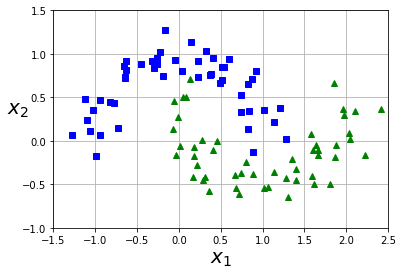

In [4]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=10, loss="hinge"))
])
polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

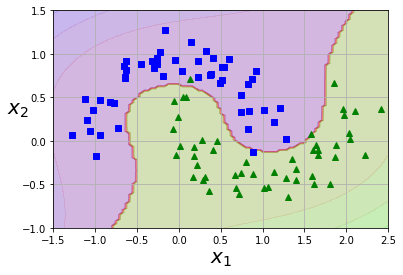

In [6]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

### Tips：
为了避免每次使用PolynimialFeatures进行转换的繁琐步骤，使用SVC中的kernel属性，

可以直接进行Nonelinear Classification操作

In [7]:
from sklearn.svm import SVC
# 省去了PolynomialFeatures处理
poly_kernel_svm_clf = Pipeline([
    ('std_scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=100, C=5))
    # 'coef0' controls how much the model is influenced by high-degree polynomials versus low-degree polymonials
])
poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=100,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

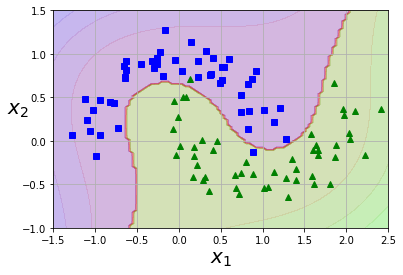

In [8]:
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

## Adding Similarity Features - RBF

Gaussian Radial Basis Function

核心思想就是设置一个landmark坐标，然后通过一个钟型函数计算其它点到这个坐标的距离，形成一组新feature。

通常的做法是每个数据点生成一个landmark坐标，以避免最终无法进行线性分类的情况。

但这种做法的问题在于最终会生成m个features，m个数据，对于大数据计算来说非常不利.

In [9]:
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel='rbf', gamma=5, C=0.001)),
])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

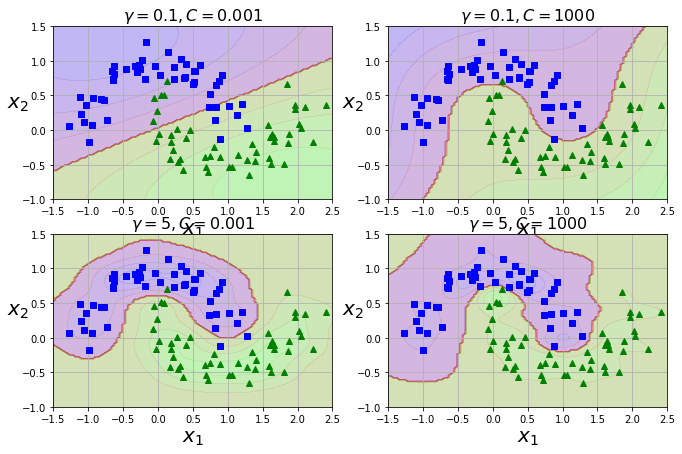

In [10]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(11, 7))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)

plt.show()

### 说明：

- gamma值越小，kernel中的钟形线越宽，相当于扩大每个点的影响范围，平滑了曲线。反之一样

- 这里C的影响跟gamma一样，可以理解为每个点的影响力，值越小，影响力越大，曲线越平滑。

### 关于kernel的选择
- 优先选择Linear，因为它最快。
- 然后，如果训练集的个数不是很多的话，也可以选择Gaussian RBF
- 最后，如果有时间有计算能力，可以利用cross-validation+grid search尝试其它kernel

### Computational Complexity
- LinearSVC基于liblinear库，对于linear算法优化非常好，计算复杂度为O(m * n)，但不能更换kernel
- SVC基于libsvm库，计算复杂度介于O(m^2 * n)到O(m^3 * n)之间，可以选择kernel，比较适用于中小训练集

## SVM Regression
与SVC不同，SVMRegression的目的是在有限的区间内尽量匹配多的点，

这个区间由参数epsilon控制，epsilon越大区间越大

In [11]:
# Linear SVM Regression
from sklearn.svm import LinearSVR
svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [12]:
# None-linear SVM Regresion
from sklearn.svm import SVR
svm_poly_reg = SVR(kernel='poly', degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### 注意：
这里的C值，与前面linear regression中的alpha作用不同，需要区分一下

- C值用于penelty error计算，就是C越大，penelty越苛刻，线条会越匹配样本，也就是越趋于overfitting(high variance)
- alpha用于regulization，alpha值越大，线条越趋于平滑，也就是越趋于underfitting(high bias)

## 几种SVM Kernel的对比

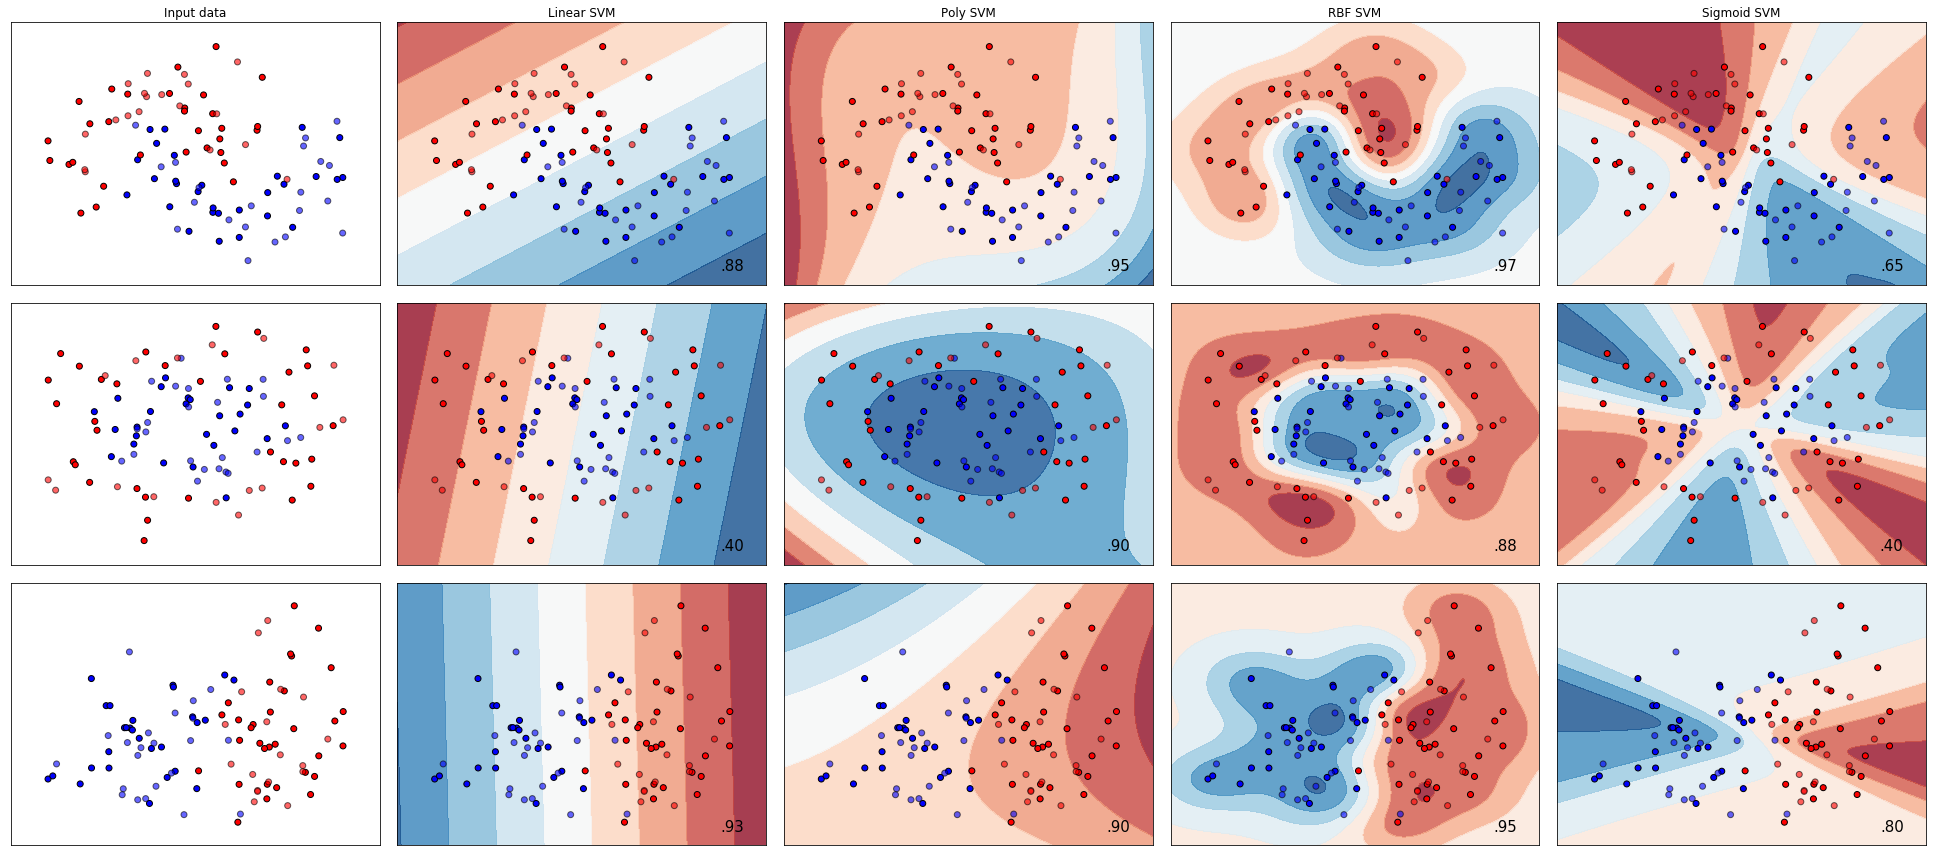

In [13]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC


h = .02  # step size in the mesh

names = ["Linear SVM", "Poly SVM", "RBF SVM", "Sigmoid SVM"]

classifiers = [
#     KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(kernel="poly", degree=3, coef0=100, C=5),
    SVC(kernel="rbf", gamma=2, C=1),
    SVC(kernel="sigmoid", gamma=2, C=1),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
#     DecisionTreeClassifier(max_depth=5),
#     RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     MLPClassifier(alpha=1),
#     AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis(),
]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 12))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()